In [308]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")


In [309]:
# Set the path to your dataset
data_path = '/kaggle/input/flowers-dataset'
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

In [310]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(factor=0.1)
])


In [311]:
# Data loading and preprocessing
from skimage import exposure
# Data loading and preprocessing
datagenerator = ImageDataGenerator(
    preprocessing_function=exposure.equalize_hist,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Assuming you want to split 20% for validation
)

batch_size = 32
train_generator = datagenerator.flow_from_directory(
    train_data_path,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = datagenerator.flow_from_directory(
    train_data_path,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [312]:
# Customizing the model based on InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

In [313]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

In [314]:
base_model.load_weights('/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [315]:
# Fine-tuning only the top layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Fine-tune the last 10 layers
    layer.trainable = False

In [316]:
# Building the final model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # 5 Output Neurons for 5 Classes
])


In [317]:
opt = optimizers.Adam(learning_rate=0.0001)  # Try different learning rates


In [318]:
# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [319]:
# Separating Training and Testing Data
batch_size = 32
epochs = 10  # Adjust the number of epochs as needed

In [320]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

In [321]:
# Displaying steps_per_epoch and validation_steps
print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 68
validation_steps : 17


In [322]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)



Epoch 1/10
68/68 [==============================] - 241s 3s/step - loss: 1.6118 - accuracy: 0.2433 - val_loss: 1.6004 - val_accuracy: 0.2151
Epoch 2/10
68/68 [==============================] - 267s 4s/step - loss: 1.5652 - accuracy: 0.3042 - val_loss: 1.5617 - val_accuracy: 0.3456
Epoch 3/10
68/68 [==============================] - 267s 4s/step - loss: 1.5452 - accuracy: 0.3158 - val_loss: 1.5851 - val_accuracy: 0.2849
Epoch 4/10
68/68 [==============================] - 230s 3s/step - loss: 1.5316 - accuracy: 0.3116 - val_loss: 1.5565 - val_accuracy: 0.3401
Epoch 5/10
68/68 [==============================] - 231s 3s/step - loss: 1.5296 - accuracy: 0.3246 - val_loss: 1.5538 - val_accuracy: 0.3382
Epoch 6/10
68/68 [==============================] - 228s 3s/step - loss: 1.5103 - accuracy: 0.3440 - val_loss: 1.5237 - val_accuracy: 0.3640
Epoch 7/10
68/68 [==============================] - 234s 3s/step - loss: 1.5030 - accuracy: 0.3416 - val_loss: 1.5429 - val_accuracy: 0.3327
Epoch 8/10
68

In [323]:
# Plot training history
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

Final Training Accuracy: 0.3560
Final Validation Accuracy: 0.3290
Final Training Loss: 1.4903
Final Validation Loss: 1.5346

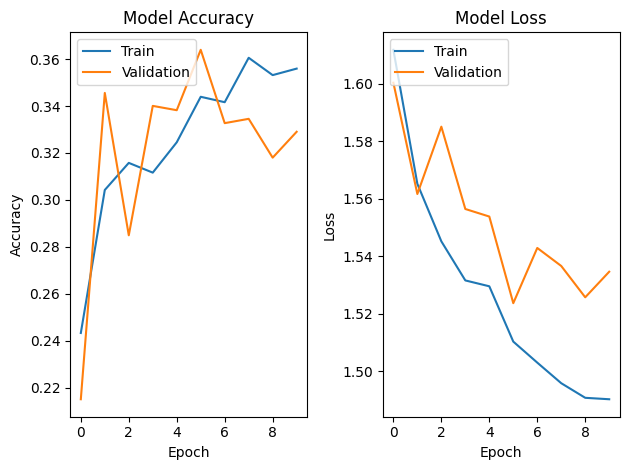

In [325]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown  # Add this line for Markdown support

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Display final accuracy and loss values
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

result_str = f'Final Training Accuracy: {final_accuracy:.4f}\nFinal Validation Accuracy: {final_val_accuracy:.4f}\nFinal Training Loss: {final_loss:.4f}\nFinal Validation Loss: {final_val_loss:.4f}'
display(Markdown(result_str))

plt.show()


In [326]:

# Customizing the model based on Xception
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [327]:
import tensorflow as tf

# Assuming you have already defined base_model_exceptionnet and model_exceptionnet
base_model_exceptionnet.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model_exceptionnet.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate
model_exceptionnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])


In [328]:

# Building the Xception model
model_xception = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')  # 5 Output Neurons for 5 Classes
])


In [329]:
# Using the Adam Optimizer to set the learning rate of our Xception model
opt_xception = optimizers.Adam(learning_rate=0.0001)


In [330]:
# Compiling the Xception model
model_xception.compile(loss="categorical_crossentropy", optimizer=opt_xception, metrics=['accuracy'])

In [331]:

# Training the Xception model
history_xception = model_xception.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)

Epoch 1/10
68/68 [==============================] - 375s 5s/step - loss: 1.5866 - accuracy: 0.2876 - val_loss: 1.5724 - val_accuracy: 0.3125
Epoch 2/10
68/68 [==============================] - 370s 5s/step - loss: 1.5488 - accuracy: 0.3153 - val_loss: 1.5649 - val_accuracy: 0.2665
Epoch 3/10
68/68 [==============================] - 374s 5s/step - loss: 1.5389 - accuracy: 0.3098 - val_loss: 1.5682 - val_accuracy: 0.3254
Epoch 4/10
68/68 [==============================] - 374s 5s/step - loss: 1.5419 - accuracy: 0.3153 - val_loss: 1.5614 - val_accuracy: 0.3107
Epoch 5/10
68/68 [==============================] - 372s 5s/step - loss: 1.5333 - accuracy: 0.3204 - val_loss: 1.5696 - val_accuracy: 0.3309
Epoch 6/10
68/68 [==============================] - 375s 5s/step - loss: 1.5270 - accuracy: 0.3204 - val_loss: 1.5564 - val_accuracy: 0.3346
Epoch 7/10
68/68 [==============================] - 377s 6s/step - loss: 1.5304 - accuracy: 0.3264 - val_loss: 1.5571 - val_accuracy: 0.3107
Epoch 8/10
68

In [332]:

# Plot training history for Xception
plt.figure(figsize=(12, 4))


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

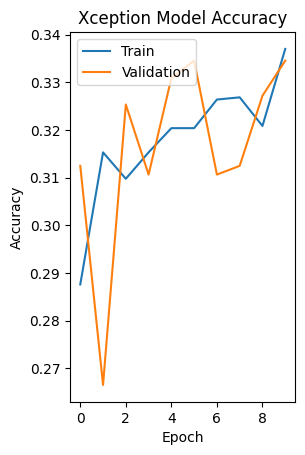

In [333]:

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.title('Xception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


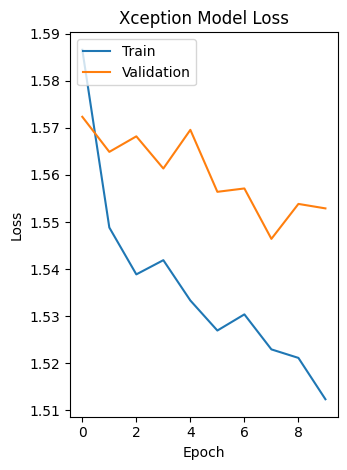

In [334]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.title('Xception Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

18/18 [==============================] - 75s 4s/step


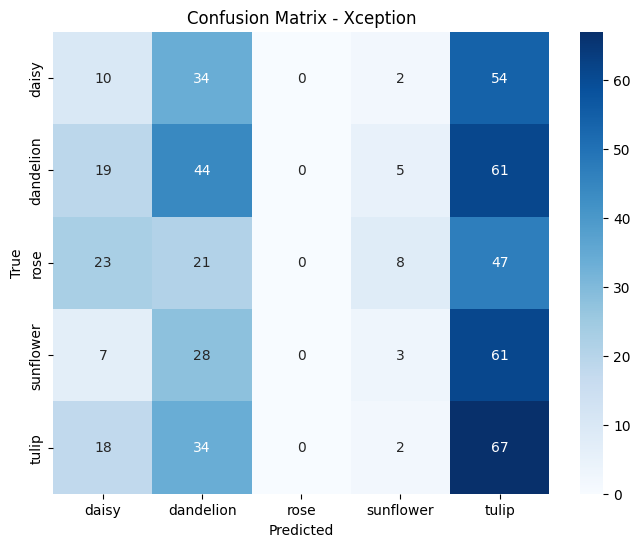

18/18 [==============================] - 75s 4s/step - loss: 1.5466 - accuracy: 0.3431


**Accuracy - Xception: 0.2263**
**Loss - Xception: 1.5466**

Classification Report - Xception:
              precision    recall  f1-score   support

       daisy       0.13      0.10      0.11       100
   dandelion       0.27      0.34      0.30       129
        rose       0.00      0.00      0.00        99
   sunflower       0.15      0.03      0.05        99
       tulip       0.23      0.55      0.33       121

    accuracy                           0.23       548
   macro avg       0.16      0.21      0.16       548
weighted avg       0.17      0.23      0.17       548


In [341]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import display, Markdown

def evaluate_and_plot_confusion_matrix(model, generator, model_name):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

    # Calculate accuracy
    accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)

    # Calculate loss (assuming the model was compiled with a loss function)
    loss = model.evaluate(generator)[0]

    # Display accuracy and loss
    result_str = f'**Accuracy - {model_name}: {accuracy:.4f}**\n**Loss - {model_name}: {loss:.4f}**\n\nClassification Report - {model_name}:\n{report}'
    
    display(Markdown(result_str))

# Example usage for Xception
evaluate_and_plot_confusion_matrix(model_xception, valid_generator, 'Xception')


In [350]:
# Customizing the model based on EfficientNetB0
from efficientnet.tfkeras import EfficientNetB0

In [351]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [353]:
import tensorflow as tf

# Assuming you have already defined base_model_efficientnet and model_efficientnet
base_model_efficientnet.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model_efficientnet.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate
model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])


In [354]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Building the EfficientNet model
model_efficientnet = Sequential([
    base_model_efficientnet,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')  # 5 Output Neurons for 5 Classes
])


In [355]:
# Using the Adam Optimizer to set the learning rate of our EfficientNet model
opt_efficientnet = optimizers.Adam(learning_rate=0.0001)


In [356]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer
opt_efficientnet = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed

# Compile the EfficientNet model
model_efficientnet.compile(loss="categorical_crossentropy", optimizer=opt_efficientnet, metrics=['accuracy'])


In [357]:

# Training the EfficientNet model
history_efficientnet = model_efficientnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)

Epoch 1/10
68/68 [==============================] - 297s 4s/step - loss: 1.6453 - accuracy: 0.2465 - val_loss: 1.9571 - val_accuracy: 0.1820
Epoch 2/10
68/68 [==============================] - 278s 4s/step - loss: 1.5085 - accuracy: 0.3130 - val_loss: 3.0045 - val_accuracy: 0.2371
Epoch 3/10
68/68 [==============================] - 277s 4s/step - loss: 1.4168 - accuracy: 0.3735 - val_loss: 6.2900 - val_accuracy: 0.2371
Epoch 4/10
68/68 [==============================] - 278s 4s/step - loss: 1.3964 - accuracy: 0.3726 - val_loss: 3.8275 - val_accuracy: 0.2371
Epoch 5/10
68/68 [==============================] - 280s 4s/step - loss: 1.3541 - accuracy: 0.4224 - val_loss: 2.4702 - val_accuracy: 0.1820
Epoch 6/10
68/68 [==============================] - 280s 4s/step - loss: 1.3200 - accuracy: 0.4367 - val_loss: 1.3789 - val_accuracy: 0.3897
Epoch 7/10
68/68 [==============================] - 280s 4s/step - loss: 1.2713 - accuracy: 0.4571 - val_loss: 1.7868 - val_accuracy: 0.2353
Epoch 8/10
68

In [358]:
# Plot training history for EfficientNet
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

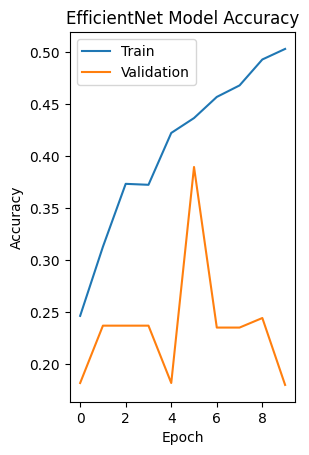

In [360]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'])
plt.plot(history_efficientnet.history['val_accuracy'])
plt.title('EfficientNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

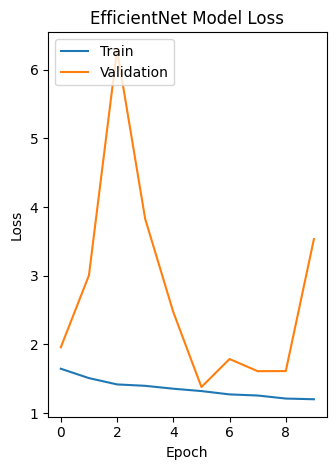

In [362]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'])
plt.plot(history_efficientnet.history['val_loss'])
plt.title('EfficientNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

18/18 [==============================] - 40s 2s/step


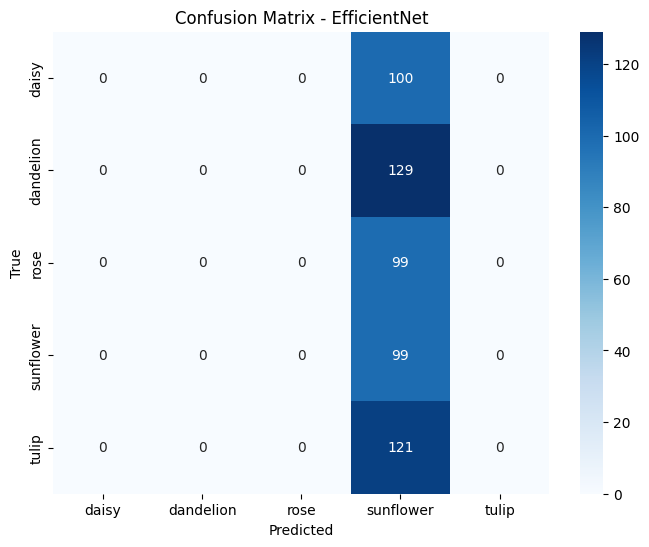

18/18 [==============================] - 40s 2s/step - loss: 3.5273 - accuracy: 0.1807


**Accuracy - EfficientNet: 0.1807**
**Loss - EfficientNet: 3.5273**

Classification Report - EfficientNet:
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       100
   dandelion       0.00      0.00      0.00       129
        rose       0.00      0.00      0.00        99
   sunflower       0.18      1.00      0.31        99
       tulip       0.00      0.00      0.00       121

    accuracy                           0.18       548
   macro avg       0.04      0.20      0.06       548
weighted avg       0.03      0.18      0.06       548


In [371]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import display, Markdown


def evaluate_and_plot_confusion_matrix(model, generator, model_name):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

    # Calculate accuracy
    accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)

    # Calculate loss (assuming the model was compiled with a loss function)
    loss = model.evaluate(generator)[0]

    # Display accuracy and loss
    result_str = f'**Accuracy - {model_name}: {accuracy:.4f}**\n**Loss - {model_name}: {loss:.4f}**\n\nClassification Report - {model_name}:\n{report}'
    
    display(Markdown(result_str))


# Example usage for EfficientNet
evaluate_and_plot_confusion_matrix(model_efficientnet, valid_generator, 'EfficientNet')



In [372]:

# Customizing the model based on MobileNetV2
from tensorflow.keras.applications import MobileNetV2


In [375]:

base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


In [377]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Assuming you have already defined base_model_mobilenetv2
base_model_mobilenetv2.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model_mobilenetv2.layers[:fine_tune_at]:
    layer.trainable = False

In [378]:
# Building the MobileNetV2 model
model_mobilenetv2 = Sequential([
    base_model_mobilenetv2,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax')  # 5 Output Neurons for 5 Classes
])

In [379]:

# Using the Adam Optimizer to set the learning rate of our MobileNetV2 model
opt_mobilenetv2 = optimizers.Adam(learning_rate=0.0001)


In [380]:

# Compiling the MobileNetV2 model
model_mobilenetv2.compile(loss="categorical_crossentropy", optimizer=opt_mobilenetv2, metrics=['accuracy'])

In [ ]:
# Training the MobileNetV2 model
history_mobilenetv2 = model_mobilenetv2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 1.6143 - accuracy: 0.2664

In [ ]:
# Plot training history for MobileNetV2
plt.figure(figsize=(12, 4))


In [ ]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'])
plt.plot(history_mobilenetv2.history['val_accuracy'])
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'])
plt.plot(history_mobilenetv2.history['val_loss'])
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import display, Markdown


def evaluate_and_plot_confusion_matrix(model, generator, model_name):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

    # Calculate accuracy
    accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)

    # Calculate loss (assuming the model was compiled with a loss function)
    loss = model.evaluate(generator)[0]

    # Display accuracy and loss
    result_str = f'**Accuracy - {model_name}: {accuracy:.4f}**\n**Loss - {model_name}: {loss:.4f}**\n\nClassification Report - {model_name}:\n{report}'
    
    display(Markdown(result_str))



# Example usage for MobileNetV2 without a history object
evaluate_and_plot_confusion_matrix(mobilenetv2_model, valid_generator, 'MobileNetV2')



# # **HRNET**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout

def create_hrnet_model(input_shape=(300, 300, 3), num_classes=5):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.15),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:

# Create HRNet model
model_hrnet = create_hrnet_model()

In [ ]:
# Using the Adam Optimizer to set the learning rate of our HRNet model
opt_hrnet = optimizers.Adam(learning_rate=0.0001)

In [ ]:

# Compiling the HRNet model
model_hrnet.compile(loss="categorical_crossentropy", optimizer=opt_hrnet, metrics=['accuracy'])


In [ ]:
# Training the HRNet model
history_hrnet = model_hrnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)

In [ ]:
# Plot training history for HRNet
plt.figure(figsize=(12, 4))


In [ ]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_hrnet.history['accuracy'])
plt.plot(history_hrnet.history['val_accuracy'])
plt.title('HRNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_hrnet.history['loss'])
plt.plot(history_hrnet.history['val_loss'])
plt.title('HRNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate HRNet model and plot confusion matrix
evaluate_and_plot_confusion_matrix(model_hrnet, valid_generator)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from IPython.display import display, Markdown


def evaluate_and_plot_confusion_matrix(model, generator, model_name):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

    # Calculate accuracy
    accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)

    # Calculate loss (assuming the model was compiled with a loss function)
    loss = model.evaluate(generator)[0]

    # Display accuracy and loss
    result_str = f'**Accuracy - {model_name}: {accuracy:.4f}**\n**Loss - {model_name}: {loss:.4f}**\n\nClassification Report - {model_name}:\n{report}'
    
    display(Markdown(result_str))


# Example usage for HRNet
evaluate_and_plot_confusion_matrix(model_hrnet, valid_generator_hrnet, 'HRNet')

